In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from scipy import ndimage
from scipy import signal
from scipy import misc
import math
import cv2
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d
from skimage.feature import peak_local_max
from operator import itemgetter

In [77]:
def rad2deg(rad):
    return rad*(180/math.pi)

def deg2rad(deg):
    return deg*(math.pi/180)

def sobel(img):
    sh = np.array([[1,0,-1], 
                   [2,0,-2], 
                   [1,0,-1]], dtype=np.float)
    sv = np.array([[-1,-2,-1], 
                   [0,0,0], 
                   [1,2,1]], dtype=np.float)
    
    gx = cv2.filter2D(img, -1, sh).astype(np.float32)
    gy = cv2.filter2D(img, -1, sv).astype(np.float32)
    
    return (gx, gy)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def gshow(img):
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

In [78]:
def tan_mag(gx, gy):
    h, w = gx.shape
    
    tans = np.zeros((h,w))
    mags = np.zeros((h,w))
    
    for y in range(h):
        for x in range(w):
            tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))
            tans[y,x] = tan
            mag = math.sqrt(gy[y,x]**2 + gx[y,x]**2)
            mags[y,x] = mag
    
    return tans, mags

In [79]:
def pre(im):
    im = rgb2gray(im)
    im = cv2.GaussianBlur(im, (5,5), 2)
    return im

In [80]:
def plot_vars(tans, mags):
    tan_arr = np.zeros_like(tans)
    mag_arr = np.zeros_like(mags)
    h, w = tans.shape
    hist = {}
    xs = np.arange(-90, 91, 2)
    for x in xs:
        hist[x] = 0
    tan_l = []
    mag_l = []
    for y in range(h):
        for x in range(w):
            if (np.isnan(tans[y,x])):
                continue
            else:
                tan_arr[y,x] = tans[y,x]
                mag_arr[y,x] = mags[y,x]
                tan_l.append(tans[y,x])
                mag_l.append(mags[y,x])
                if (int(tans[y,x]) % 2 is 0):
                    hist[int(tans[y,x])] += mags[y,x]
                else:
                    hist[int(tans[y,x]) - 1] += mags[y,x]
    
    return hist, tan_arr, mag_arr

In [81]:
def edf_smooth(hist, sigma=9):
    k = []
    v = []
    for co in hist.items():
        k.append(co[0])
        v.append(co[1])
    new_k = []
    c = -90
    while c <= 90:
        new_k.append(c)
        c += 0.5
    new_v = []
    for i in range(90):
        diff = v[i+1] - v[i]
        step = diff/4
        for j in range(4):
            new_v.append(v[i] + step * j)
    new_v.append(0.0)
    smoothy = gaussian_filter1d(new_v, sigma)
    smoothx = new_k
    
    return smoothx, smoothy

In [82]:
def edf_comp(img, title='test', sigma=13, ret=True):
    gray_blur = pre(img)
    gx, gy = sobel(gray_blur)
    tans, mags = tan_mag(gx, gy)
    hist, tan_arr, mag_arr = plot_vars(tans, mags)
    x, y = edf_smooth(hist, sigma=sigma)
    plt.plot(x, y)
    plt.show()
    if ret:
        return y, tan_arr, mag_arr
    
def get_maxima(y):
    x = np.linspace(-90, 90, 360)
    maxm = argrelextrema(y, np.greater)
    maxm = x[maxm]
    return maxm

def filter_maxima(maxm):
    valid_matches = []
    l = maxm.shape[0]
    fp = 0
    lp = l-1
    while (lp is not fp) and (lp > fp):
        diff = abs(maxm[fp] + maxm[lp])
        if diff < 20.0:
            valid_matches.append(fp)
            valid_matches.append(lp)
            fp += 1
            lp -= 1
        else:
            if abs(maxm[fp] > maxm[lp]):
                fp += 1
            else:
                lp -= 1
                
    return maxm[valid_matches]

def single_edge_image(tan_arr, mag_arr, alpha):
    h, w = tan_arr.shape
    single_edge_image = np.zeros_like(mag_arr)
    for y in range(h):
        for x in range(w):
            if abs(tan_arr[y,x] - alpha) < 2.0:
                single_edge_image[y,x] = mag_arr[y,x]
                
    return single_edge_image

In [83]:
def get_edges_thetas(y, tan_arr, mag_arr):
    maxm = np.sort(get_maxima(y))
    vm = np.sort(filter_maxima(maxm))
    edges = []
    for i in range(vm.shape[0]):
        edges.append(single_edge_image(tan_arr, mag_arr, vm[i]))
    return edges, vm

C:\Users\ms\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in float_scalars
  if __name__ == '__main__':
C:\Users\ms\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in float_scalars
  if __name__ == '__main__':


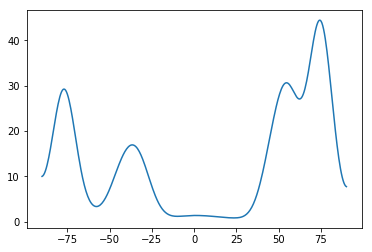

[-76.9637883  -36.35097493  54.90250696  74.45682451]
[-76.9637883  -36.35097493   1.25348189  54.90250696  74.45682451]


In [85]:
img = mpimg.imread('img/road.png')
y, tan_arr, mag_arr = edf_comp(img, 'Road')
maxm = np.sort(get_maxima(y))
vm = np.sort(filter_maxima(maxm))
edges = []
print(vm)
for i in range(vm.shape[0]):
    edges.append(single_edge_image(tan_arr, mag_arr, vm[i]))
#for edge in edges:
    #gshow(edge)
print(maxm)

In [86]:
def vm_to_hough(vm):
    ret = np.zeros_like(vm)
    for i in range(vm.shape[0]):
        if vm[i] < 0:
            ret[i] = -90 - vm[i]
        else:
            ret[i] = 90 - vm[i]
    return ret


def weighted_hough(edge_img, theta, mag_arr):
    t = deg2rad(theta)
    h, w = edge_img.shape
    diag = int(math.ceil(math.sqrt(h**2 + w**2)))
    acc = np.zeros(2*diag+1)
    for y in range(h):
        for x in range(w):
            if edge_img[y,x] > 0:
                rho = int((y * math.sin(t) + x * math.cos(t)) + diag)
                acc[rho] += mag_arr[y,x]
                
    return acc, diag, theta

In [143]:
def line(rho, alpha, h, w, thicc=5):
    line_im = np.zeros((h, w)).astype(np.uint8)
    point_list = []
    for x in range(w):
        y = int( -x / math.tan(alpha * (math.pi/180)) + (rho / (math.sin(alpha*(math.pi/180)))))
        if (y < h and y >= 0):
            point_list.append((x, y))
    
    point_list.sort(key=itemgetter(1))
    last = len(point_list) - 1
    cv2.line(line_im, point_list[0], point_list[last], (255,255,255), thickness=thicc)
    return line_im

def draw_on_img(gray, edges, vm, mag_arr):
    gray_lines = np.copy(gray)
    h, w = gray.shape
    h_degs = vm_to_hough(vm)
    for i in range(len(edges)):
        edge_im = edges[i]
        theta = h_degs[i]
        acc, diag, theta = weighted_hough(edge_im, theta, mag_arr)
        smooth_acc = gaussian_filter1d(acc, sigma=51)
        x = np.arange(0, 2*diag+1, 1)
        maxm = argrelextrema(smooth_acc, np.greater)
        maxm = x[maxm]
        
        points = []
        for maxima in maxm:
            points.append((maxima, smooth_acc[maxima]))
        points.sort(key=itemgetter(1))
        
        rho = points[-1][0] - diag
        
        line_img = line(rho, theta, h, w)
        gray_lines += line_img
    
    return gray_lines

In [134]:
mod = vm_to_hough(vm)
ac, d, t = weighted_hough(edges[1], mod[1], mag_arr)

[  3 335]


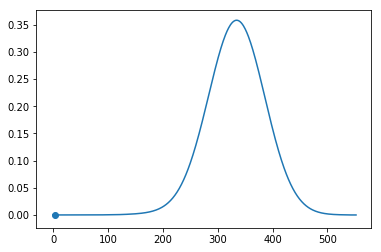

-273


In [144]:
sm = gaussian_filter1d(ac, sigma=51)
maxm = argrelextrema(sm, np.greater)
maxm = x[maxm]
print(maxm)

plt.plot(sm)
plt.scatter(maxm[0], sm[maxm[0]])
plt.show()

r_val = maxm[0] - d
print(r_val)

In [136]:
def line(rho, alpha, h, w, thicc=5):
    line_im = np.zeros((h, w)).astype(np.uint8)
    point_list = []
    for x in range(w):
        y = int( -x / math.tan(alpha * (math.pi/180)) + (rho / (math.sin(alpha*(math.pi/180)))))
        if (y < h and y >= 0):
            point_list.append((x, y))
    
    point_list.sort(key=itemgetter(1))
    last = len(point_list) - 1
    if last>=0:
        cv2.line(line_im, point_list[0], point_list[last], (255,255,255), thickness=thicc)
    return line_im

In [137]:
h, w = mag_arr.shape
l = line(r_val, t, h, w)

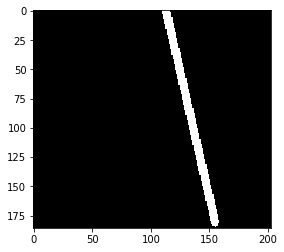

In [118]:
gshow(l)

C:\Users\ms\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in float_scalars
  if __name__ == '__main__':
C:\Users\ms\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in float_scalars
  if __name__ == '__main__':


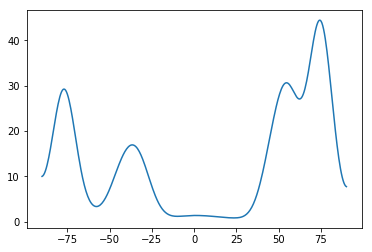

110
59
75
99


In [141]:
test = mpimg.imread('img/road.png')
gray = rgb2gray(test)
y, tan_arr, mag_arr = edf_comp(test)
edges, vm = get_edges_thetas(y, tan_arr, mag_arr)
gray_lines = draw_on_img(gray, edges, vm, mag_arr)

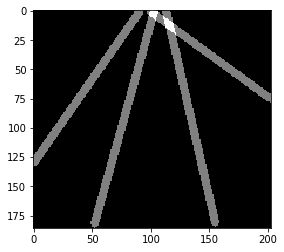

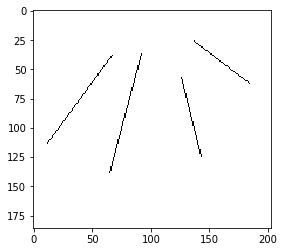

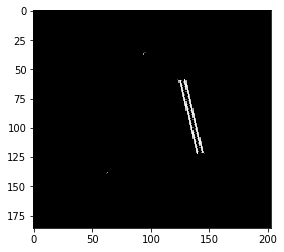

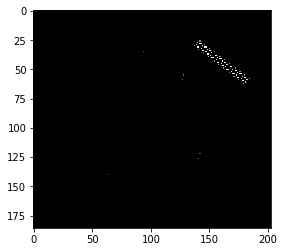

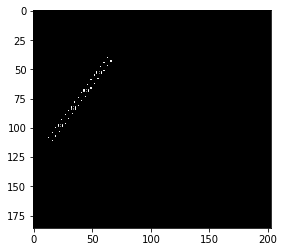

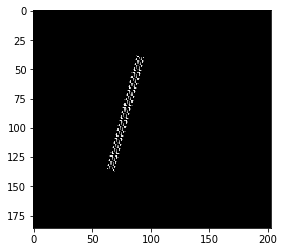

In [142]:
gshow(gray_lines)
gshow(gray)
for edge in edges:
    gshow(edge)